<a href="https://colab.research.google.com/github/nmach22/Claude-Monet-painting-generator/blob/main/model_experiment_CycleGAN_U-Net.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Prepare Data

## Install Required Libraries

In [1]:
! pip install kaggle==1.5.16 --upgrade -q
! pip install wandb --upgrade -q

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 83.6/83.6 kB 4.5 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done


## Download and unzip kaggle files

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
! mkdir ~/.kaggle

In [4]:
! cp /content/drive/MyDrive/ColabNotebooks/kaggle_API_credentials/kaggle.json ~/.kaggle/kaggle.json

In [5]:
! chmod 600 ~/.kaggle/kaggle.json

In [6]:
! kaggle competitions download -c gan-getting-started

100% 367M/367M [00:03<00:00, 91.4MB/s]
100% 367M/367M [00:03<00:00, 107MB/s] 


In [7]:
! unzip -q /content/gan-getting-started.zip

## login Wandb

In [8]:
import wandb

wandb.login()

wandb.init(
    project="Generate Monet paintings",
    entity="nmach22-free-university-of-tbilisi-"
)

/usr/local/lib/python3.12/dist-packages/notebook/notebookapp.py:191: SyntaxWarning: invalid escape sequence '\/'
  | |_| | '_ \/ _` / _` |  _/ -_)
wandb: (1) Create a W&B account
wandb: (2) Use an existing W&B account
wandb: (3) Don't visualize my results
wandb: Enter your choice:

 2


wandb: You chose 'Use an existing W&B account'
wandb: Logging into https://api.wandb.ai. (Learn how to deploy a W&B server locally: https://wandb.me/wandb-server)
wandb: Find your API key here: https://wandb.ai/authorize
wandb: Paste an API key from your profile and hit enter:

 ··········


wandb: No netrc file found, creating one.
wandb: Appending key for api.wandb.ai to your netrc file: /root/.netrc
wandb: Currently logged in as: nmach22 (zeliz22-free-university-of-tbilisi-) to https://api.wandb.ai. Use `wandb login --relogin` to force relogin


## Imports

In [9]:
import glob
import itertools
import matplotlib.pyplot as plt
import numpy as np
import os
from PIL import Image
import random
from sklearn.model_selection import GroupKFold
from sklearn.metrics import roc_curve
from sklearn import metrics
import time
from tqdm.notebook import tqdm

import torch
import torch.nn as nn
import torch.nn.init as init
from torch.utils.data import Dataset, DataLoader

import torchvision.transforms as transforms

### Seed

In [10]:
def set_seed(seed):
    random.seed(seed)
    os.environ['PYTHONHASHSEED'] = str(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.backends.cudnn.deterministic = True

In [11]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'
device

'cuda'

In [12]:
set_seed(42)

# Dataset And DataLoader

In [13]:
class ImageDataset(Dataset):
    def __init__(self, monet_dir, photo_dir, filenames=None, size=(256, 256), normalize=True):
        super().__init__()
        self.monet_dir = monet_dir
        self.photo_dir = photo_dir

        # If filenames are provided (for val/test), use them.
        # Otherwise, load the full directory (for training).
        if filenames is not None:
            self.photo_filenames = filenames
        else:
            self.photo_filenames = os.listdir(self.photo_dir)
        self.monet_filenames = os.listdir(self.monet_dir)

        layers = [transforms.Resize(size), transforms.ToTensor()]
        if normalize:
            layers.append(transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5)))
        self.transform = transforms.Compose(layers)

        self.monet_len = len(self.monet_filenames)
        self.photo_len = len(self.photo_filenames)

    def __getitem__(self, idx):
        photo_path = os.path.join(self.photo_dir, self.photo_filenames[idx % self.photo_len])
        monet_path = os.path.join(self.monet_dir, self.monet_filenames[idx % self.monet_len])

        photo_img = self.transform(Image.open(photo_path).convert("RGB"))
        monet_img = self.transform(Image.open(monet_path).convert("RGB"))

        return photo_img, monet_img

    def __len__(self):
        return max(self.photo_len, self.monet_len)

In [14]:
from sklearn.model_selection import train_test_split

monet_dir = './monet_jpg/'
photo_dir = './photo_jpg/'

# Get all photo names
all_photos = os.listdir('./photo_jpg/')

# Split: 80% train, 20% for the rest
train_files, temp_files = train_test_split(all_photos, test_size=0.2, random_state=42)

# Split the 20% into half validation (10%) and half test (10%)
val_files, test_files = train_test_split(temp_files, test_size=0.5, random_state=42)

# Create the three datasets
train_dataset = ImageDataset(monet_dir, photo_dir, filenames=train_files)
val_dataset = ImageDataset(monet_dir, photo_dir, filenames=val_files)
test_dataset = ImageDataset(monet_dir, photo_dir, filenames=test_files)

In [15]:
img_dl = DataLoader(train_dataset, batch_size=32, pin_memory=True)

In [16]:
def unnorm(img, mean=[0.5, 0.5, 0.5], std=[0.5, 0.5, 0.5]):
    for t, m, s in zip(img, mean, std):
        t.mul_(s).add_(s)

    return img

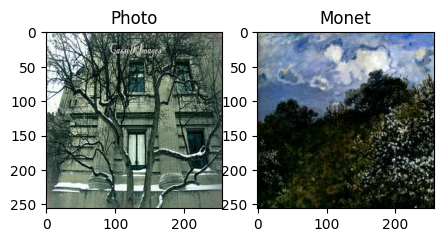

In [17]:
photo_img, monet_img = next(iter(img_dl))

f = plt.figure(figsize=(5, 5))

f.add_subplot(1, 2, 1)
plt.title('Photo')
photo_img = unnorm(photo_img)
plt.imshow(photo_img[0].permute(1, 2, 0))

f.add_subplot(1, 2, 2)
plt.title('Monet')
monet_img = unnorm(monet_img)
plt.imshow(monet_img[0].permute(1, 2, 0))

## Load and Save chackpoints

In [18]:
def load_checkpoint(ckpt_path, map_location=None):
    ckpt = torch.load(ckpt_path, map_location=map_location)
    print(' [*] Loading checkpoint from %s succeed!' % ckpt_path)
    return ckpt

def save_checkpoint(state, save_path):
    torch.save(state, save_path)

# Model

### Upsample and DownSample

In [19]:
class Downsample(nn.Module):
  """
  Downsample block for U-Net encoder (contracting path)
  - Conv2d with stride=2 to reduce spatial dimensions by half
  - InstanceNorm2d for normalization (optional, typically skipped in first layer)
  - LeakyReLU activation
  """
  def __init__(self, in_ch, out_ch, normalize=True, dropout=0.0):
      super().__init__()
      layers = [
          nn.Conv2d(in_ch, out_ch, kernel_size=4, stride=2, padding=1, bias=False)
      ]

      if normalize:
          layers.append(nn.InstanceNorm2d(out_ch))

      layers.append(nn.LeakyReLU(0.2, inplace=True))

      if dropout:
          layers.append(nn.Dropout(dropout))

      self.model = nn.Sequential(*layers)

  def forward(self, x):
      return self.model(x)

In [20]:
class Upsample(nn.Module):
    """
    Upsample block for U-Net decoder (expanding path)
    - ConvTranspose2d with stride=2 to increase spatial dimensions by 2x
    - InstanceNorm2d for normalization
    - Dropout for regularization (optional)
    - ReLU activation
    """
    def __init__(self, in_ch, out_ch, dropout=0.0):
        super().__init__()
        layers = [
            nn.ConvTranspose2d(in_ch, out_ch, kernel_size=4, stride=2, padding=1, bias=False),
            nn.InstanceNorm2d(out_ch),
            nn.ReLU(inplace=True)
        ]

        if dropout:
            layers.append(nn.Dropout(dropout))

        self.model = nn.Sequential(*layers)

    def forward(self, x, skip_input):
        x = self.model(x)
        return torch.cat((x, skip_input), 1)


### U-Net Generator

In [21]:
class Generator(nn.Module):
    """
    U-Net Generator for CycleGAN
    Architecture: Encoder-Decoder with skip connections
    Input: 3-channel image (RGB)
    Output: 3-channel image (RGB)
    """
    def __init__(self, in_ch=3, out_ch=3, base_ch=64):
        super(Generator, self).__init__()

        # Encoder (Contracting Path)
        self.down1 = Downsample(in_ch, base_ch, normalize=False)      # 128x128
        self.down2 = Downsample(base_ch, base_ch*2)                   # 64x64
        self.down3 = Downsample(base_ch*2, base_ch*4)                 # 32x32
        self.down4 = Downsample(base_ch*4, base_ch*8, dropout=0.5)    # 16x16
        self.down5 = Downsample(base_ch*8, base_ch*8, dropout=0.5)    # 8x8
        self.down6 = Downsample(base_ch*8, base_ch*8, dropout=0.5)    # 4x4
        self.down7 = Downsample(base_ch*8, base_ch*8, dropout=0.5)    # 2x2

        # Bottleneck
        self.bottleneck = Downsample(base_ch*8, base_ch*8, normalize=False, dropout=0.5)  # 1x1

        # Decoder (Expanding Path)
        self.up1 = Upsample(base_ch*8, base_ch*8, dropout=0.5)        # 2x2
        self.up2 = Upsample(base_ch*16, base_ch*8, dropout=0.5)       # 4x4
        self.up3 = Upsample(base_ch*16, base_ch*8, dropout=0.5)       # 8x8
        self.up4 = Upsample(base_ch*16, base_ch*8, dropout=0.5)       # 16x16
        self.up5 = Upsample(base_ch*16, base_ch*4)                    # 32x32
        self.up6 = Upsample(base_ch*8, base_ch*2)                     # 64x64
        self.up7 = Upsample(base_ch*4, base_ch)                       # 128x128

        # Final output layer
        self.final = nn.Sequential(
            nn.ConvTranspose2d(base_ch*2, out_ch, kernel_size=4, stride=2, padding=1),
            nn.Tanh()  # Output in range [-1, 1]
        )

    def forward(self, x):
        # Encoder with skip connections
        d1 = self.down1(x)                # 128x128
        d2 = self.down2(d1)               # 64x64
        d3 = self.down3(d2)               # 32x32
        d4 = self.down4(d3)               # 16x16
        d5 = self.down5(d4)               # 8x8
        d6 = self.down6(d5)               # 4x4
        d7 = self.down7(d6)               # 2x2

        # Bottleneck
        bottleneck = self.bottleneck(d7)  # 1x1

        # Decoder with skip connections (concatenate)
        u1 = self.up1(bottleneck, d7)     # 2x2
        u2 = self.up2(u1, d6)             # 4x4
        u3 = self.up3(u2, d5)             # 8x8
        u4 = self.up4(u3, d4)             # 16x16
        u5 = self.up5(u4, d3)             # 32x32
        u6 = self.up6(u5, d2)             # 64x64
        u7 = self.up7(u6, d1)             # 128x128

        # Final output
        output = self.final(u7)           # 256x256

        return output

#### Test Generator

In [22]:
# Initialize generator
generator = Generator(in_ch=3, out_ch=3, base_ch=64).to(device)

# Print model architecture
print(generator)
print("\n" + "="*80)
print(f"Total parameters: {sum(p.numel() for p in generator.parameters()):,}")
print(f"Trainable parameters: {sum(p.numel() for p in generator.parameters() if p.requires_grad):,}")

Generator(
  (down1): Downsample(
    (model): Sequential(
      (0): Conv2d(3, 64, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
      (1): LeakyReLU(negative_slope=0.2, inplace=True)
    )
  )
  (down2): Downsample(
    (model): Sequential(
      (0): Conv2d(64, 128, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
      (1): InstanceNorm2d(128, eps=1e-05, momentum=0.1, affine=False, track_running_stats=False)
      (2): LeakyReLU(negative_slope=0.2, inplace=True)
    )
  )
  (down3): Downsample(
    (model): Sequential(
      (0): Conv2d(128, 256, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
      (1): InstanceNorm2d(256, eps=1e-05, momentum=0.1, affine=False, track_running_stats=False)
      (2): LeakyReLU(negative_slope=0.2, inplace=True)
    )
  )
  (down4): Downsample(
    (model): Sequential(
      (0): Conv2d(256, 512, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
      (1): InstanceNorm2d(512, eps=1e-05, moment

In [23]:
# Test with random input
test_input = torch.randn(1, 3, 256, 256).to(device)
test_output = generator(test_input)
print(f"Input shape: {test_input.shape}")
print(f"Output shape: {test_output.shape}")
print(f"Output range: [{test_output.min().item():.3f}, {test_output.max().item():.3f}]")


Input shape: torch.Size([1, 3, 256, 256])
Output shape: torch.Size([1, 3, 256, 256])
Output range: [-1.000, 1.000]


### Discriminator (PatchGAN)

In [24]:
class Discriminator(nn.Module):
    """
    PatchGAN Discriminator for CycleGAN
    - Classifies whether overlapping image patches are real or fake
    - Outputs a matrix of predictions rather than a single value
    - Uses 70x70 receptive field (patch size)
    """
    def __init__(self, in_ch=3, base_ch=64):
        super(Discriminator, self).__init__()

        def conv_block(in_features, out_features, normalize=True):
            layers = [nn.Conv2d(in_features, out_features, kernel_size=4, stride=2, padding=1)]
            if normalize:
                layers.append(nn.InstanceNorm2d(out_features))
            layers.append(nn.LeakyReLU(0.2, inplace=True))
            return layers

        # 70x70 PatchGAN
        self.model = nn.Sequential(
            # C64: No normalization in first layer
            *conv_block(in_ch, base_ch, normalize=False),        # 256 → 128
            # C128: With normalization
            *conv_block(base_ch, base_ch*2),                     # 128 → 64
            # C256: With normalization
            *conv_block(base_ch*2, base_ch*4),                   # 64 → 32
            # C512: With normalization, stride=1
            *conv_block(base_ch*4, base_ch*8),                   # 32 → 16
            # Final output layer: Single channel output (patch predictions)
            nn.Conv2d(base_ch*8, 1, kernel_size=4, padding=1)    # 16 → ~14 (patch map)
        )

    def forward(self, x):
        return self.model(x)


#### Test Discriminator

In [25]:
# Initialize discriminator
discriminator = Discriminator(in_ch=3, base_ch=64).to(device)

# Print model architecture
print(discriminator)
print("\n" + "="*80)
print(f"Total parameters: {sum(p.numel() for p in discriminator.parameters()):,}")
print(f"Trainable parameters: {sum(p.numel() for p in discriminator.parameters() if p.requires_grad):,}")

Discriminator(
  (model): Sequential(
    (0): Conv2d(3, 64, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
    (1): LeakyReLU(negative_slope=0.2, inplace=True)
    (2): Conv2d(64, 128, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
    (3): InstanceNorm2d(128, eps=1e-05, momentum=0.1, affine=False, track_running_stats=False)
    (4): LeakyReLU(negative_slope=0.2, inplace=True)
    (5): Conv2d(128, 256, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
    (6): InstanceNorm2d(256, eps=1e-05, momentum=0.1, affine=False, track_running_stats=False)
    (7): LeakyReLU(negative_slope=0.2, inplace=True)
    (8): Conv2d(256, 512, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
    (9): InstanceNorm2d(512, eps=1e-05, momentum=0.1, affine=False, track_running_stats=False)
    (10): LeakyReLU(negative_slope=0.2, inplace=True)
    (11): Conv2d(512, 1, kernel_size=(4, 4), stride=(1, 1), padding=(1, 1))
  )
)

Total parameters: 2,764,737
Trainable parameters: 2,764,737


In [26]:
# Test with random input
test_input = torch.randn(1, 3, 256, 256).to(device)
test_output = discriminator(test_input)
print(f"Input shape: {test_input.shape}")
print(f"Output shape: {test_output.shape}")
print(f"Output is a matrix of patch predictions (PatchGAN)")
print(f"Each value represents real/fake prediction for a receptive field")


Input shape: torch.Size([1, 3, 256, 256])
Output shape: torch.Size([1, 1, 15, 15])
Output is a matrix of patch predictions (PatchGAN)
Each value represents real/fake prediction for a receptive field


In [27]:
def init_weights(net, init_type='normal', gain=0.02):
    def init_func(m):
        classname = m.__class__.__name__
        if hasattr(m, 'weight') and (classname.find('Conv') != -1 or classname.find('Linear') != -1):
            init.normal_(m.weight.data, 0.0, gain)
            if hasattr(m, 'bias') and m.bias is not None:
                init.constant_(m.bias.data, 0.0)
        elif classname.find('BatchNorm2d') != -1:
            init.normal_(m.weight.data, 1.0, gain)
            init.constant_(m.bias.data, 0.0)
    net.apply(init_func)

## Additional Functions

In [28]:
def update_req_grad(models, requires_grad=True):
    for model in models:
        for param in model.parameters():
            param.requires_grad = requires_grad


In [29]:
# https://arxiv.org/pdf/1612.07828.pdf
# Save 50 generated fake imgs and sample through them
# to feed discriminators to avoid large oscillations
# from iterations to iterations.
class sample_fake(object):
    def __init__(self, max_imgs=50):
        self.max_imgs = max_imgs
        self.cur_img = 0
        self.imgs = []

    def __call__(self, images):
        ret = []
        for image in images:
            image = image.detach().cpu()
            if self.cur_img < self.max_imgs:
                self.imgs.append(image)
                ret.append(image)
                self.cur_img += 1
            else:
                if np.random.ranf() > 0.5:
                    idx = np.random.randint(0, self.max_imgs)
                    ret.append(self.imgs[idx])
                    self.imgs[idx] = image
                else:
                    ret.append(image)
        return torch.stack(ret)

In [30]:
class lr_sched():
    def __init__(self, decay_epochs=100, total_epochs=200):
        self.decay_epochs = decay_epochs
        self.total_epochs = total_epochs

    def step(self, epoch_num):
        if epoch_num <= self.decay_epochs:
            return 1.0
        else:
            fract = (epoch_num - self.decay_epochs) / (self.total_epochs - self.decay_epochs)
            return 1.0 - fract

In [31]:
class AvgStats(object):
    def __init__(self):
        self.reset()

    def reset(self):
        self.losses = []
        self.its = []

    def append(self, loss, it):
        self.losses.append(loss)
        self.its.append(it)

## Define GAN Class

In [32]:
class CycleGAN(object):
    def __init__(self, in_ch, out_ch, epochs, device, start_lr=2e-4, lmbda=10, idt_coef=0.5, adv_coef=1.0, decay_epoch=0):
        self.epochs = epochs
        self.decay_epoch = decay_epoch if decay_epoch > 0 else int(self.epochs/2)
        self.lmbda = lmbda
        self.idt_coef = idt_coef
        self.adv_coef = adv_coef
        self.device = device
        self.gen_mtp = Generator(in_ch, out_ch)
        self.gen_ptm = Generator(in_ch, out_ch)
        self.desc_m = Discriminator(in_ch)
        self.desc_p = Discriminator(in_ch)
        self.init_models()
        self.mse_loss = nn.MSELoss()
        self.l1_loss = nn.L1Loss()
        self.adam_gen = torch.optim.Adam(itertools.chain(self.gen_mtp.parameters(), self.gen_ptm.parameters()),
                                         lr = start_lr, betas=(0.5, 0.999))
        self.adam_desc = torch.optim.Adam(itertools.chain(self.desc_m.parameters(), self.desc_p.parameters()),
                                          lr=start_lr, betas=(0.5, 0.999))
        self.sample_monet = sample_fake()
        self.sample_photo = sample_fake()
        gen_lr = lr_sched(self.decay_epoch, self.epochs)
        desc_lr = lr_sched(self.decay_epoch, self.epochs)
        self.gen_lr_sched = torch.optim.lr_scheduler.LambdaLR(self.adam_gen, gen_lr.step)
        self.desc_lr_sched = torch.optim.lr_scheduler.LambdaLR(self.adam_desc, desc_lr.step)
        self.gen_stats = AvgStats()
        self.desc_stats = AvgStats()
        self.start_epoch = 0

    def init_models(self):
        init_weights(self.gen_mtp)
        init_weights(self.gen_ptm)
        init_weights(self.desc_m)
        init_weights(self.desc_p)
        self.gen_mtp = self.gen_mtp.to(self.device)
        self.gen_ptm = self.gen_ptm.to(self.device)
        self.desc_m = self.desc_m.to(self.device)
        self.desc_p = self.desc_p.to(self.device)

    def load_weights(self, ckpt_path):
        ckpt = load_checkpoint(ckpt_path)
        self.start_epoch = ckpt['epoch']
        self.gen_mtp.load_state_dict(ckpt['gen_mtp'])
        self.gen_ptm.load_state_dict(ckpt['gen_ptm'])
        self.desc_m.load_state_dict(ckpt['desc_m'])
        self.desc_p.load_state_dict(ckpt['desc_p'])
        self.adam_gen.load_state_dict(ckpt['optimizer_gen'])
        self.adam_desc.load_state_dict(ckpt['optimizer_desc'])

    def log_generated_images(self, epoch, photo_img, monet_img):
        # Take only the first image (fixed sample)
        sample_photos = photo_img[:1]
        sample_monets = monet_img[:1]

        # Generate fakes
        with torch.no_grad():
            fake_monets = self.gen_ptm(sample_photos)
            fake_photos = self.gen_mtp(sample_monets)

        # Unnormalize for display: [-1, 1] -> [0, 1]
        sample_photos = sample_photos * 0.5 + 0.5
        sample_monets = sample_monets * 0.5 + 0.5
        fake_monets = fake_monets * 0.5 + 0.5
        fake_photos = fake_photos * 0.5 + 0.5

        # Create a list of wandb.Image objects with captions
        log_images = []
        log_photos = []

        for j in range(len(sample_monets)):
            # Log Monet -> Photo
            log_photos.append(wandb.Image(sample_monets[j], caption=f"Real Monet {j}"))
            log_photos.append(wandb.Image(fake_photos[j], caption=f"Generated Photo {j}"))

        for j in range(len(sample_photos)):
            # Log Photo -> Fake Monet
            log_images.append(wandb.Image(sample_photos[j], caption=f"Real Photo {j}"))
            log_images.append(wandb.Image(fake_monets[j], caption=f"Generated Monet {j}"))

        # Log to W&B
        wandb.log({
            "Visuals/Monet_to_Photo": log_photos,
            "Visuals/Photo_to_Monet": log_images,
            "Epoch": epoch + 1
        })

    def train(self, photo_dl):
        # Fix one photo (batch) before train starts to log the same image throughout training
        fixed_iter = iter(photo_dl)
        fixed_photo_sample, fixed_monet_sample = next(fixed_iter)
        fixed_photo_sample = fixed_photo_sample.to(self.device)
        fixed_monet_sample = fixed_monet_sample.to(self.device)

        for epoch in range(self.start_epoch, self.start_epoch + self.epochs):
            start_time = time.time()
            avg_gen_loss = 0.0
            avg_desc_loss = 0.0
            t = tqdm(photo_dl, leave=False, total=photo_dl.__len__())
            for i, (photo_real, monet_real) in enumerate(t):
                photo_img, monet_img = photo_real.to(device), monet_real.to(device)
                update_req_grad([self.desc_m, self.desc_p], False)
                self.adam_gen.zero_grad()

                # Forward pass through generator
                fake_photo = self.gen_mtp(monet_img)
                fake_monet = self.gen_ptm(photo_img)

                cycl_monet = self.gen_ptm(fake_photo)
                cycl_photo = self.gen_mtp(fake_monet)

                id_monet = self.gen_ptm(monet_img)
                id_photo = self.gen_mtp(photo_img)

                # generator losses - identity, Adversarial, cycle consistency
                idt_loss_monet = self.l1_loss(id_monet, monet_img) * self.lmbda * self.idt_coef
                idt_loss_photo = self.l1_loss(id_photo, photo_img) * self.lmbda * self.idt_coef

                cycle_loss_monet = self.l1_loss(cycl_monet, monet_img) * self.lmbda
                cycle_loss_photo = self.l1_loss(cycl_photo, photo_img) * self.lmbda

                monet_desc = self.desc_m(fake_monet)
                photo_desc = self.desc_p(fake_photo)

                real = torch.ones(monet_desc.size()).to(self.device)

                adv_loss_monet = self.mse_loss(monet_desc, real) * self.adv_coef
                adv_loss_photo = self.mse_loss(photo_desc, real) * self.adv_coef

                # total generator loss
                total_gen_loss = cycle_loss_monet + adv_loss_monet\
                              + cycle_loss_photo + adv_loss_photo\
                              + idt_loss_monet + idt_loss_photo

                avg_gen_loss += total_gen_loss.item()

                # backward pass
                total_gen_loss.backward()
                self.adam_gen.step()

                # Forward pass through Descriminator
                update_req_grad([self.desc_m, self.desc_p], True)
                self.adam_desc.zero_grad()

                fake_monet = self.sample_monet(fake_monet).to(self.device).detach()
                fake_photo = self.sample_photo(fake_photo).to(self.device).detach()

                monet_desc_real = self.desc_m(monet_img)
                monet_desc_fake = self.desc_m(fake_monet)
                photo_desc_real = self.desc_p(photo_img)
                photo_desc_fake = self.desc_p(fake_photo)

                real = torch.ones(monet_desc_real.size()).to(self.device)
                fake = torch.zeros(monet_desc_fake.size()).to(self.device)

                # Descriminator losses
                # --------------------
                monet_desc_real_loss = self.mse_loss(monet_desc_real, real)
                monet_desc_fake_loss = self.mse_loss(monet_desc_fake, fake)
                photo_desc_real_loss = self.mse_loss(photo_desc_real, real)
                photo_desc_fake_loss = self.mse_loss(photo_desc_fake, fake)

                monet_desc_loss = (monet_desc_real_loss + monet_desc_fake_loss) / 2
                photo_desc_loss = (photo_desc_real_loss + photo_desc_fake_loss) / 2
                total_desc_loss = monet_desc_loss + photo_desc_loss
                avg_desc_loss += total_desc_loss.item()

                # Backward
                monet_desc_loss.backward()
                photo_desc_loss.backward()
                self.adam_desc.step()

                wandb.log({
                    "Generator Loss": total_gen_loss.item(),
                    "Discriminator Loss": total_desc_loss.item(),
                    "Epoch": epoch
                })

                t.set_postfix(gen_loss=total_gen_loss.item(), desc_loss=total_desc_loss.item())

            # Log the fixed image at the end of every epoch
            self.log_generated_images(epoch, fixed_photo_sample, fixed_monet_sample)

            save_dict = {
                'epoch': epoch+1,
                'gen_mtp': self.gen_mtp.state_dict(),
                'gen_ptm': self.gen_ptm.state_dict(),
                'desc_m': self.desc_m.state_dict(),
                'desc_p': self.desc_p.state_dict(),
                'optimizer_gen': self.adam_gen.state_dict(),
                'optimizer_desc': self.adam_desc.state_dict()
            }
            if (epoch + 1) % 5 == 0:
                save_checkpoint(save_dict, f'./drive/MyDrive/checkpoints/U-Net/checkpoint_{epoch+1}.ckpt')

            avg_gen_loss /= photo_dl.__len__()
            avg_desc_loss /= photo_dl.__len__()
            time_req = time.time() - start_time

            self.gen_stats.append(avg_gen_loss, time_req)
            self.desc_stats.append(avg_desc_loss, time_req)

            print("Epoch: (%d) | Generator Loss:%f | Discriminator Loss:%f" %
                                                (epoch+1, avg_gen_loss, avg_desc_loss))

            self.gen_lr_sched.step()
            self.desc_lr_sched.step()

In [33]:
gan = CycleGAN(3, 3, 30, device, idt_coef=0.05, adv_coef=2.0)

In [34]:
# Save before train
def save_parameters():
    return {
        'epoch': 0,
        'gen_mtp': gan.gen_mtp.state_dict(),
        'gen_ptm': gan.gen_ptm.state_dict(),
        'desc_m': gan.desc_m.state_dict(),
        'desc_p': gan.desc_p.state_dict(),
        'optimizer_gen': gan.adam_gen.state_dict(),
        'optimizer_desc': gan.adam_desc.state_dict()
    }

In [ ]:
checkpoint_dir = './drive/MyDrive/checkpoints/U-Net'
os.makedirs(checkpoint_dir, exist_ok=True)

# Find all checkpoints
checkpoints = glob.glob(os.path.join(checkpoint_dir, '*.ckpt'))

if checkpoints:
    # Select the latest checkpoint based on modification time
    latest_ckpt = max(checkpoints, key=os.path.getctime)
    print(f"Found checkpoint: {latest_ckpt}")
    gan.load_weights(latest_ckpt)
    print(f"Resuming from epoch {gan.start_epoch}")
else:
    save_dict = save_parameters()
    save_checkpoint(save_dict, './drive/MyDrive/checkpoints/U-Net/init.ckpt')
    print("No checkpoint found, starting from epoch 0")

gan.train(img_dl)

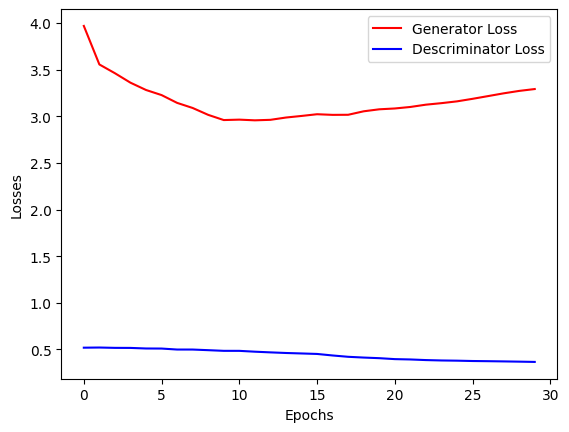

In [36]:
plt.xlabel("Epochs")
plt.ylabel("Losses")
plt.plot(gan.gen_stats.losses, 'r', label='Generator Loss')
plt.plot(gan.desc_stats.losses, 'b', label='Descriminator Loss')
plt.legend()
plt.show()

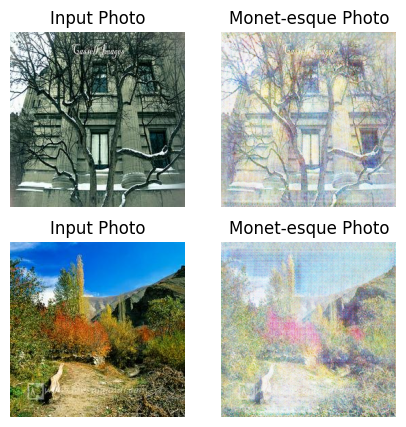

In [37]:
it = iter(img_dl)
photo_img0, _ = next(it)
photo_img0 = unnorm(photo_img0)

photo_img1, _ = next(it)
photo_img1 = unnorm(photo_img1)
def plot_input_output():
    _, ax = plt.subplots(2, 2, figsize=(5, 5))
    for i in range(2):
        photo_img = photo_img0 if i == 0 else photo_img1
        pred_monet = gan.gen_ptm(photo_img.to(device)).cpu().detach()
        pred_monet = unnorm(pred_monet)

        ax[i, 0].imshow(photo_img[0].permute(1, 2, 0))
        ax[i, 1].imshow(pred_monet[0].permute(1, 2, 0))
        ax[i, 0].set_title("Input Photo")
        ax[i, 1].set_title("Monet-esque Photo")
        ax[i, 0].axis("off")
        ax[i, 1].axis("off")
    plt.show()

plot_input_output()

In [38]:
ckpts = glob.glob(os.path.join(checkpoint_dir, '*.ckpt'))
for ckpt in ckpts:
    print(f"checkpoint path: {ckpt}")

checkpoint path: ./drive/MyDrive/checkpoints/U-Net/init.ckpt
checkpoint path: ./drive/MyDrive/checkpoints/U-Net/checkpoint_1.ckpt
checkpoint path: ./drive/MyDrive/checkpoints/U-Net/checkpoint_5.ckpt
checkpoint path: ./drive/MyDrive/checkpoints/U-Net/checkpoint_10.ckpt
checkpoint path: ./drive/MyDrive/checkpoints/U-Net/checkpoint_15.ckpt
checkpoint path: ./drive/MyDrive/checkpoints/U-Net/checkpoint_20.ckpt
checkpoint path: ./drive/MyDrive/checkpoints/U-Net/checkpoint_25.ckpt
checkpoint path: ./drive/MyDrive/checkpoints/U-Net/checkpoint_30.ckpt


 [*] Loading checkpoint from ./drive/MyDrive/checkpoints/U-Net/init.ckpt succeed!
checkpoint path: ./drive/MyDrive/checkpoints/U-Net/init.ckpt


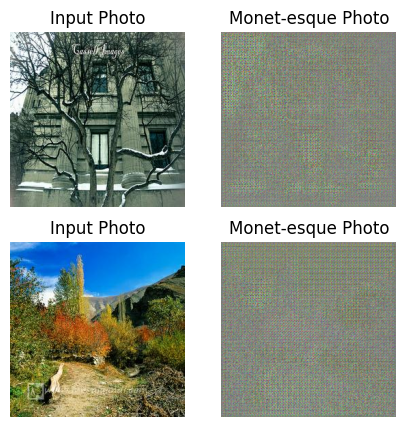

 [*] Loading checkpoint from ./drive/MyDrive/checkpoints/U-Net/checkpoint_1.ckpt succeed!
checkpoint path: ./drive/MyDrive/checkpoints/U-Net/checkpoint_1.ckpt


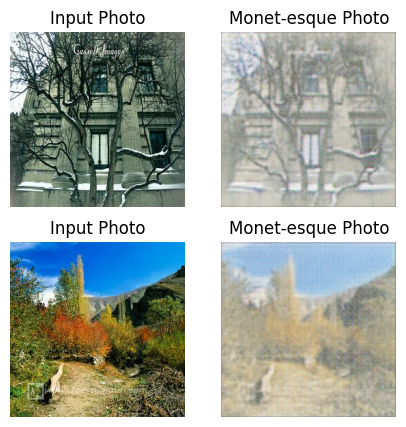

 [*] Loading checkpoint from ./drive/MyDrive/checkpoints/U-Net/checkpoint_5.ckpt succeed!
checkpoint path: ./drive/MyDrive/checkpoints/U-Net/checkpoint_5.ckpt


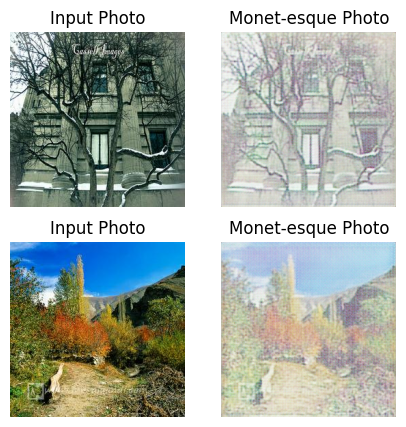

 [*] Loading checkpoint from ./drive/MyDrive/checkpoints/U-Net/checkpoint_10.ckpt succeed!
checkpoint path: ./drive/MyDrive/checkpoints/U-Net/checkpoint_10.ckpt


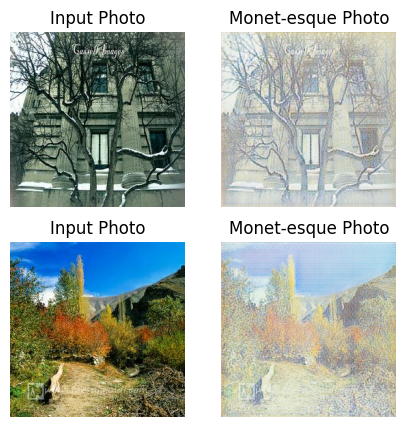

 [*] Loading checkpoint from ./drive/MyDrive/checkpoints/U-Net/checkpoint_15.ckpt succeed!
checkpoint path: ./drive/MyDrive/checkpoints/U-Net/checkpoint_15.ckpt


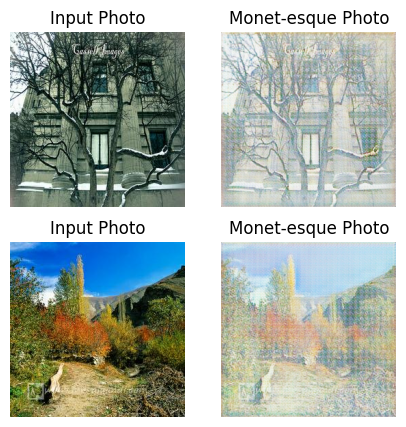

 [*] Loading checkpoint from ./drive/MyDrive/checkpoints/U-Net/checkpoint_20.ckpt succeed!
checkpoint path: ./drive/MyDrive/checkpoints/U-Net/checkpoint_20.ckpt


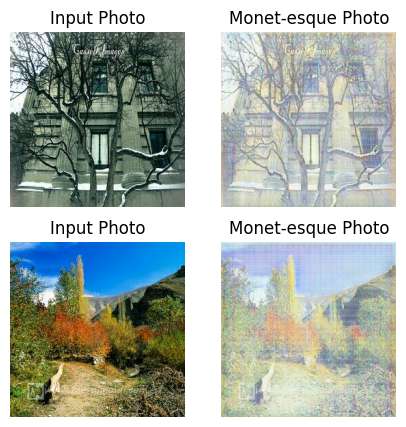

 [*] Loading checkpoint from ./drive/MyDrive/checkpoints/U-Net/checkpoint_25.ckpt succeed!
checkpoint path: ./drive/MyDrive/checkpoints/U-Net/checkpoint_25.ckpt


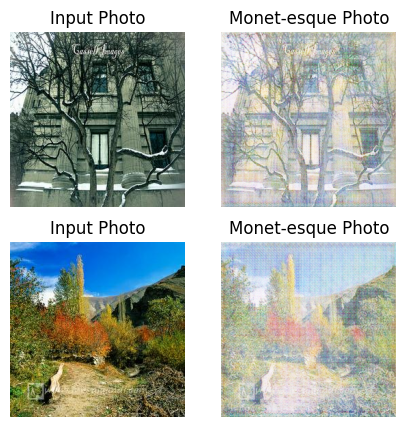

 [*] Loading checkpoint from ./drive/MyDrive/checkpoints/U-Net/checkpoint_30.ckpt succeed!
checkpoint path: ./drive/MyDrive/checkpoints/U-Net/checkpoint_30.ckpt


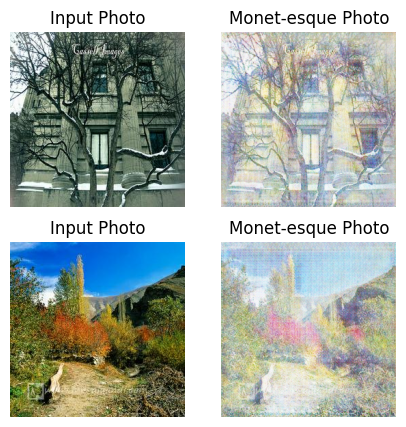

In [39]:
for ckpt in ckpts:
    gan.load_weights(ckpt)
    print(f"checkpoint path: {ckpt}")
    plot_input_output()